In [1]:
import os
import psycopg2
from dotenv import load_dotenv
from sshtunnel import SSHTunnelForwarder
import time
import pandas as pd
import numpy as np
import statsmodels
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
# Load environment variables from .env file
load_dotenv("environment_variables.env")
psql_pw = os.getenv("PSQL_PW")

# Get data
## DB Connection

In [3]:
# Connect to AWS RDS instance through AWS EC2 instance

# SSH parameters
bastion_host = 'ec2-34-224-93-62.compute-1.amazonaws.com'
bastion_user = 'ec2-user'
# bastion_key = 'C:\\Users\\detto\\Documents\\ec2-key-pair.pem'
bastion_key = "/Users/adettor/Documents/YouTubeViewPrediction/ec2-key-pair.pem"

# RDS parameters
rds_host = 'youtubeviewprediction.cd0c8oow2pnr.us-east-1.rds.amazonaws.com'
rds_user = 'postgres'
rds_password = psql_pw
rds_database = 'YouTubeViewPrediction'
rds_port = 5432

try:
    # Create an SSH tunnel
    tunnel = SSHTunnelForwarder(
        (bastion_host, 22),
        ssh_username=bastion_user,
        ssh_pkey=bastion_key,
        remote_bind_address=(rds_host, rds_port),
        local_bind_address=('localhost', 6543)  # Choose a local port for the tunnel
    )

    # Start the tunnel
    tunnel.start()

    # Connect to PostgreSQL through the tunnel
    conn = psycopg2.connect(
        database=rds_database,
        user=rds_user,
        password=rds_password,
        host=tunnel.local_bind_host,
        port=tunnel.local_bind_port
    )

    # Create a cursor object
    cursor = conn.cursor()

    # Execute a SQL query
    cursor.execute("SELECT version();")

    # Fetch result
    record = cursor.fetchone()
    print("You are connected to - ", record)

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL:", error)

You are connected to -  ('PostgreSQL 16.1 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 7.3.1 20180712 (Red Hat 7.3.1-12), 64-bit',)


## Turn SQL tables in to Pandas dataframes

In [4]:
video_fact = pd.read_sql_query("SELECT * FROM video_fact", conn)
video_dim = pd.read_sql_query("SELECT * FROM video_dim", conn)
channel_fact = pd.read_sql_query("SELECT * FROM channel_fact", conn)
channel_dim = pd.read_sql_query("SELECT * FROM channel_dim", conn)
categories_dim = pd.read_sql_query("SELECT * FROM categories_dim", conn)

In [5]:
conn.close()
cursor.close()
tunnel.stop()

# EDA
## video_fact

In [6]:
video_fact.shape

(76640, 5)

In [7]:
video_fact.dtypes

collected_at    datetime64[ns]
video_id                object
num_views                int64
num_likes                int64
num_comments             int64
dtype: object

In [8]:
video_fact.describe()

,collected_at,num_views,num_likes,num_comments
count,76640,7.664000e+04,7.664000e+04,76640.000000
mean,2024-08-01 04:58:44.787735552,2.956596e+06,1.151528e+05,7626.128406
min,2024-07-20 21:00:06.211863,3.034000e+04,0.000000e+00,0.000000
25%,2024-07-28 06:00:05.959416064,4.859678e+05,1.313000e+04,995.000000
50%,2024-08-01 21:00:05.643932928,9.741410e+05,3.168550e+04,2432.000000
75%,2024-08-05 15:00:05.390416896,2.076172e+06,7.735250e+04,4982.000000
max,2024-08-08 18:00:05.781603,2.186434e+08,8.317661e+06,385935.000000
std,NaN,1.147493e+07,5.243870e+05,29266.494294


Some videos have 0 likes and/or 0 comments

In [9]:
video_fact[["collected_at", "video_id"]].nunique()

collected_at    152
video_id        806
dtype: int64

In [10]:
video_fact.isna().sum()

collected_at    0
video_id        0
num_views       0
num_likes       0
num_comments    0
dtype: int64

### video_id

In [11]:
id_counts = video_fact["video_id"].value_counts()
id_counts

video_id
laNA2HgwYXU    152
6CXWUjjcQxg    152
j7YgKocz2W4    152
O_A8HdCDaWM    152
P1jGg5nMoyc    152
              ... 
hx8k9RSK9D8      1
-QDckQ6S4VM      1
f3L7kf2oHcs      1
Azn6r5wTd48      1
G6Y9qPI7nA4      1
Name: count, Length: 806, dtype: int64

Text(0, 0.5, 'Number of Time Points Collected')

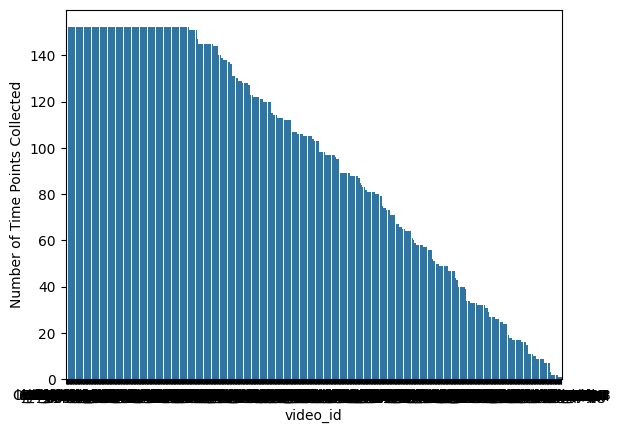

In [12]:
ax = sns.barplot(x=id_counts.index, y=id_counts)
ax.set_ylabel("Number of Time Points Collected")

In [13]:
id_counts2 = id_counts.value_counts()
id_counts2.sort_index(inplace=True, ascending=False)
id_counts2

count
152    200
151     13
149      1
147      1
145     24
      ... 
9       14
7        9
3        2
2       11
1        6
Name: count, Length: 94, dtype: int64

Text(0, 0.5, 'Number of Videos')

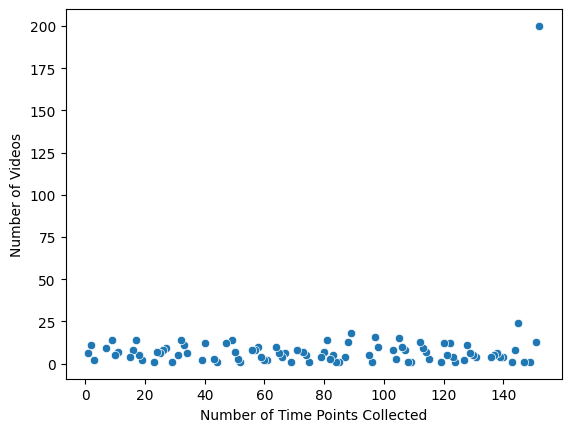

In [14]:
ax = sns.scatterplot(x=id_counts2.index, y=id_counts2)
ax.set_xlabel("Number of Time Points Collected")
ax.set_ylabel("Number of Videos")

In [15]:
ids = id_counts.sample(15).index
print(ids)

Index(['E6Sfs1dbn38', 'zM0qdqXSprY', '-QDckQ6S4VM', '5mWkn0Xb6KM',
       'XRCprhlz4D8', 'IjBjm6vm2D0', 'jlq5zhyCBvk', 'p6mhC5Iatns',
       'fTFS58mHJh8', 'w8952Nyj9T8', '-xNK5EaOfI4', 'jOmjGWoZZoI',
       'hYXo2Kkj6qY', '2qnLMkG_dNM', 'YXuwOCvXCPU'],
      dtype='object', name='video_id')


### num_views

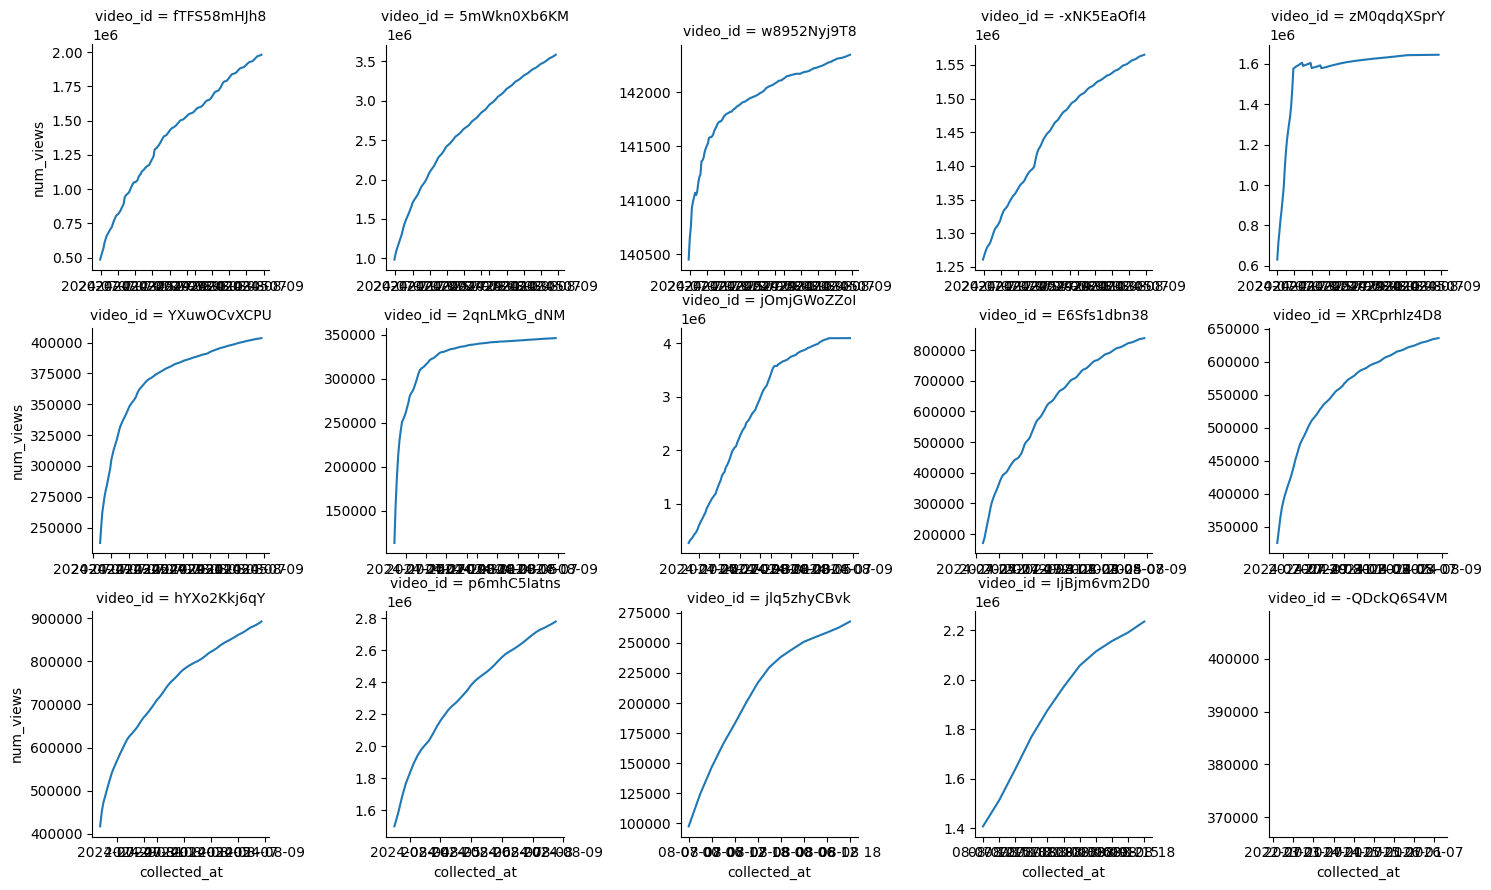

In [16]:
col = "num_views"
id_data = video_fact.loc[video_fact["video_id"].isin(ids), ["video_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="video_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

### num_comments

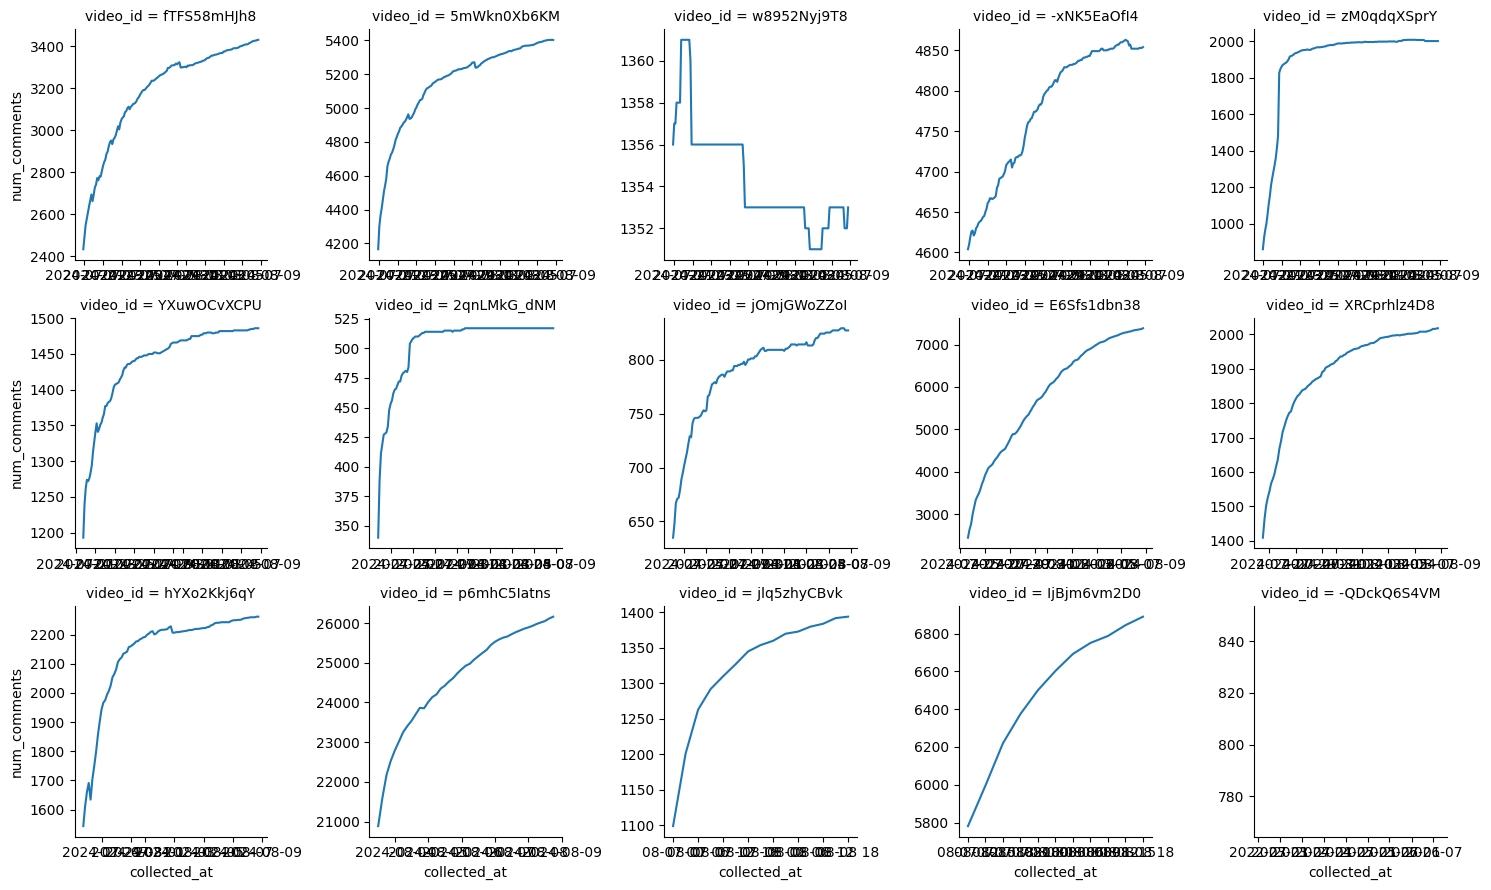

In [17]:
col = "num_comments"
id_data = video_fact.loc[video_fact["video_id"].isin(ids), ["video_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="video_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

### num_likes

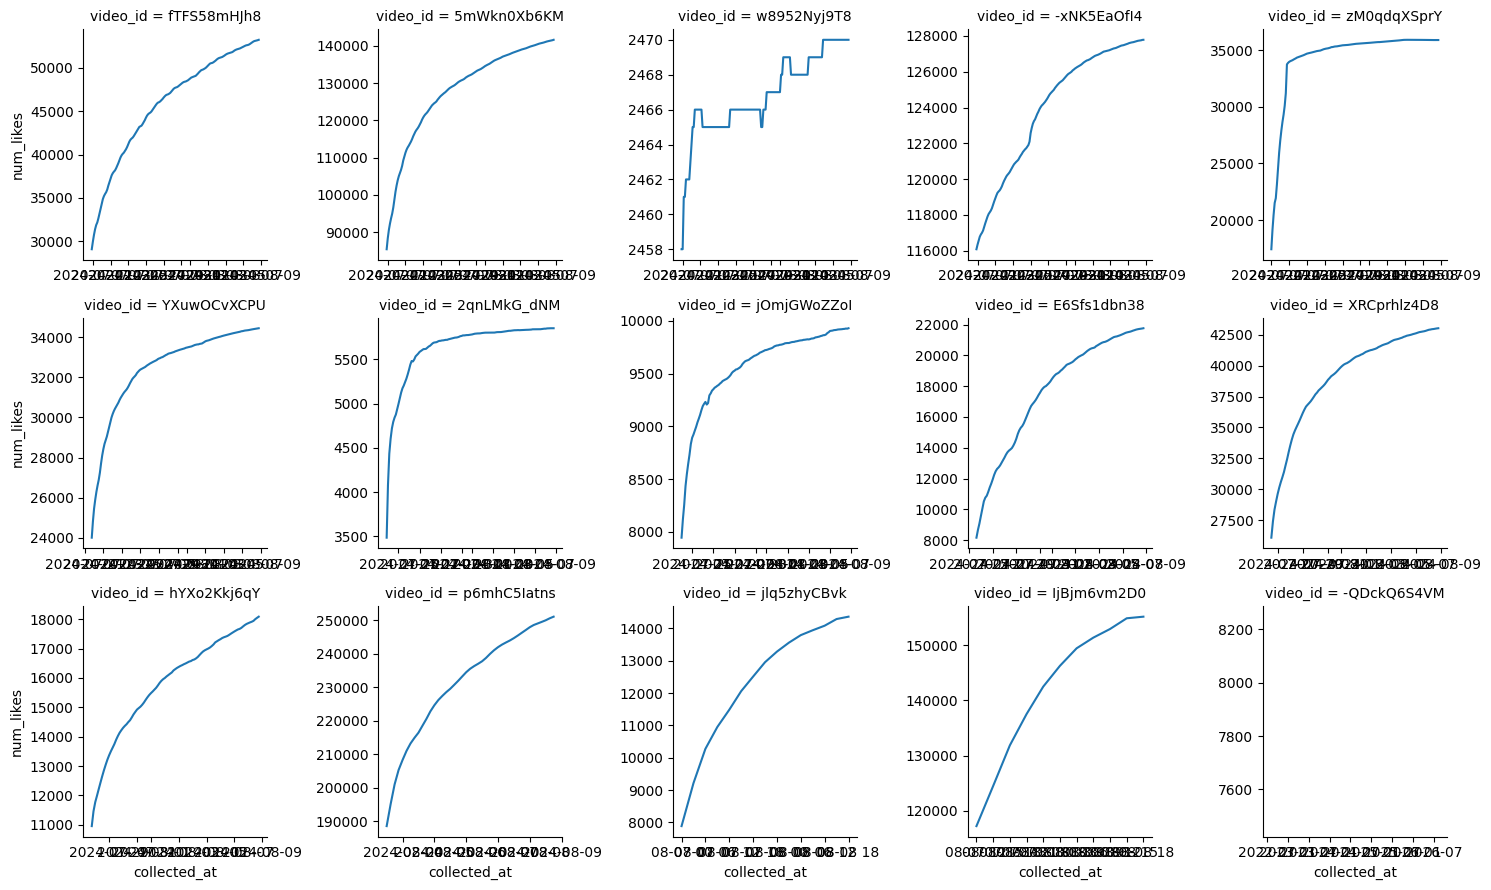

In [18]:
col = "num_likes"
id_data = video_fact.loc[video_fact["video_id"].isin(ids), ["video_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="video_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

## channel_fact

In [19]:
channel_fact.shape

(62443, 5)

In [20]:
channel_fact.dtypes

collected_at           datetime64[ns]
channel_id                     object
channel_total_views             int64
num_subscribers                 int64
num_videos                      int64
dtype: object

In [21]:
channel_fact.describe()

,collected_at,channel_total_views,num_subscribers,num_videos
count,62443,6.244300e+04,6.244300e+04,62443.000000
mean,2024-07-31 22:46:45.951151616,2.374935e+09,5.972854e+06,6381.889467
min,2024-07-20 21:00:07.479465,0.000000e+00,1.670000e+02,1.000000
25%,2024-07-27 21:00:07.899198976,1.684962e+08,6.510000e+05,216.000000
50%,2024-08-01 15:00:08.446949888,6.295669e+08,1.920000e+06,666.000000
75%,2024-08-05 09:00:08.221345024,1.849034e+09,5.430000e+06,2528.000000
max,2024-08-08 18:00:09.212975,8.681897e+10,3.090000e+08,295037.000000
std,NaN,5.754426e+09,1.768353e+07,22711.494471


Some channels have total views hidden. At least one channel has 1 video?!

In [22]:
channel_fact[["collected_at", "channel_id"]].nunique()

collected_at    152
channel_id      607
dtype: int64

In [23]:
channel_fact.isna().sum()

collected_at           0
channel_id             0
channel_total_views    0
num_subscribers        0
num_videos             0
dtype: int64

### channel_id

In [24]:
id_counts = channel_fact["channel_id"].value_counts()
id_counts

channel_id
UC2OREBiIbDChxvmDeg30Bsg    152
UC5sGdW8Jf7ijogDhcIFRmlw    152
UC7ABaoK3AFxuy_i4f6xV1tA    152
UCY6Ij8zOds0WJEeqCLOnqOQ    152
UCJbYdyufHR-cxOuY96KIoqA    152
                           ... 
UCRXiA3h1no_PFkb1JCP0yMA      2
UCZko_COpTM4_d2kPrxZfzFg      1
UCOTPo2y-NHJjg1EuENrxypA      1
UCfd0Qf-79ravG1az8_7tBfw      1
UC-F3kTU4V680v550AavEOsQ      1
Name: count, Length: 607, dtype: int64

Text(0, 0.5, 'Number of Time Points Collected')

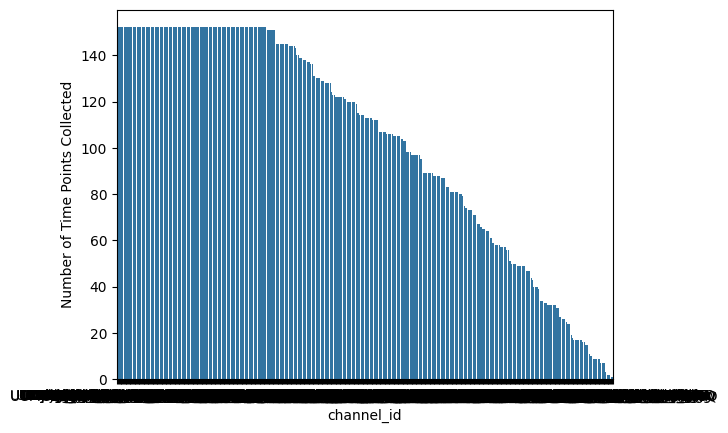

In [25]:
ax = sns.barplot(x=id_counts.index, y=id_counts)
ax.set_ylabel("Number of Time Points Collected")

In [26]:
id_counts2 = id_counts.value_counts()
id_counts2.sort_index(inplace=True, ascending=False)
id_counts2

count
152    183
151     11
145     16
144      8
143      1
      ... 
9       10
7        6
3        2
2        4
1        4
Name: count, Length: 84, dtype: int64

Text(0, 0.5, 'Number of Videos')

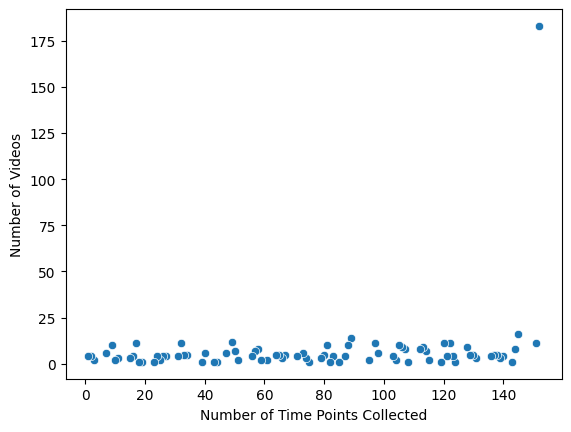

In [27]:
ax = sns.scatterplot(x=id_counts2.index, y=id_counts2)
ax.set_xlabel("Number of Time Points Collected")
ax.set_ylabel("Number of Videos")

In [28]:
ids = id_counts.sample(15).index
print(ids)

Index(['UCDK9qD5DAQML-pzrtA7A4oA', 'UC3sznuotAs2ohg_U__Jzj_Q',
       'UC8ha6SsRNvDGkwcPTCXkW3g', 'UChnCHKoRNSo_lW97pcDa08w',
       'UCgUueMmSpcl-aCTt5CuCKQw', 'UCWOA1ZGywLbqmigxE4Qlvuw',
       'UChsvwjv3ApZNAz3oeiUAWWQ', 'UCtiObj3CsEAdNU6ZPWDsddQ',
       'UCzhtAFR4aiLOr8IWqA92-5w', 'UCDq5v10l4wkV5-ZBIJJFbzQ',
       'UCGKx5XhGuf09VERiw_QIemA', 'UCP-Ng5SXUEt0VE-TXqRdL6g',
       'UCxoKaKMzulp6sfQGOhNJnzQ', 'UClwddNv0Cr6SIEGkzVK886w',
       'UC2OREBiIbDChxvmDeg30Bsg'],
      dtype='object', name='channel_id')


### channel_total_views

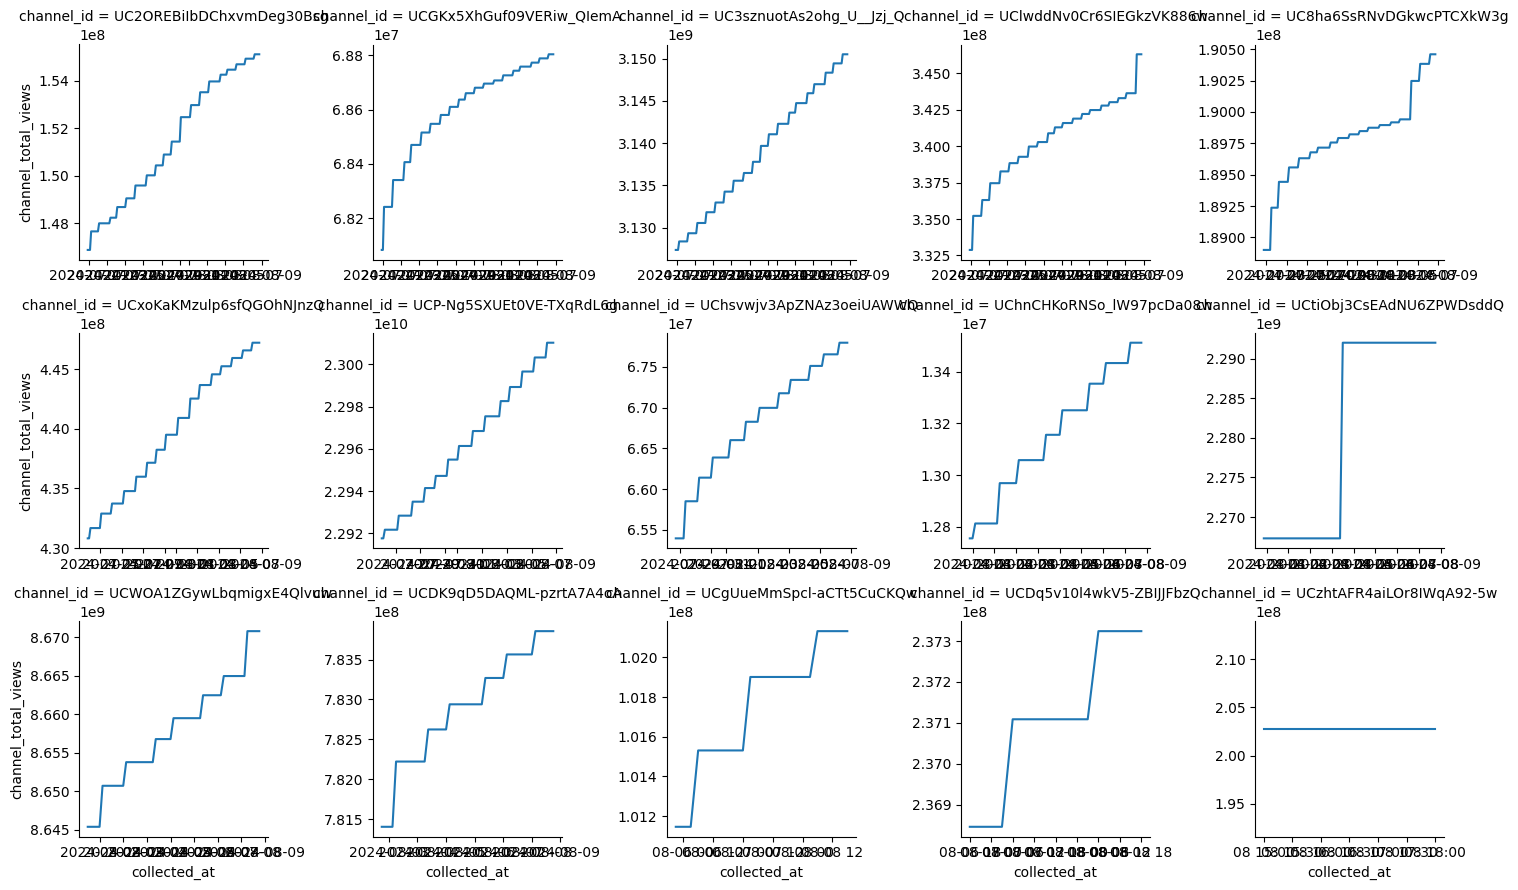

In [29]:
col = "channel_total_views"
id_data = channel_fact.loc[channel_fact["channel_id"].isin(ids), ["channel_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="channel_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

### num_subscribers

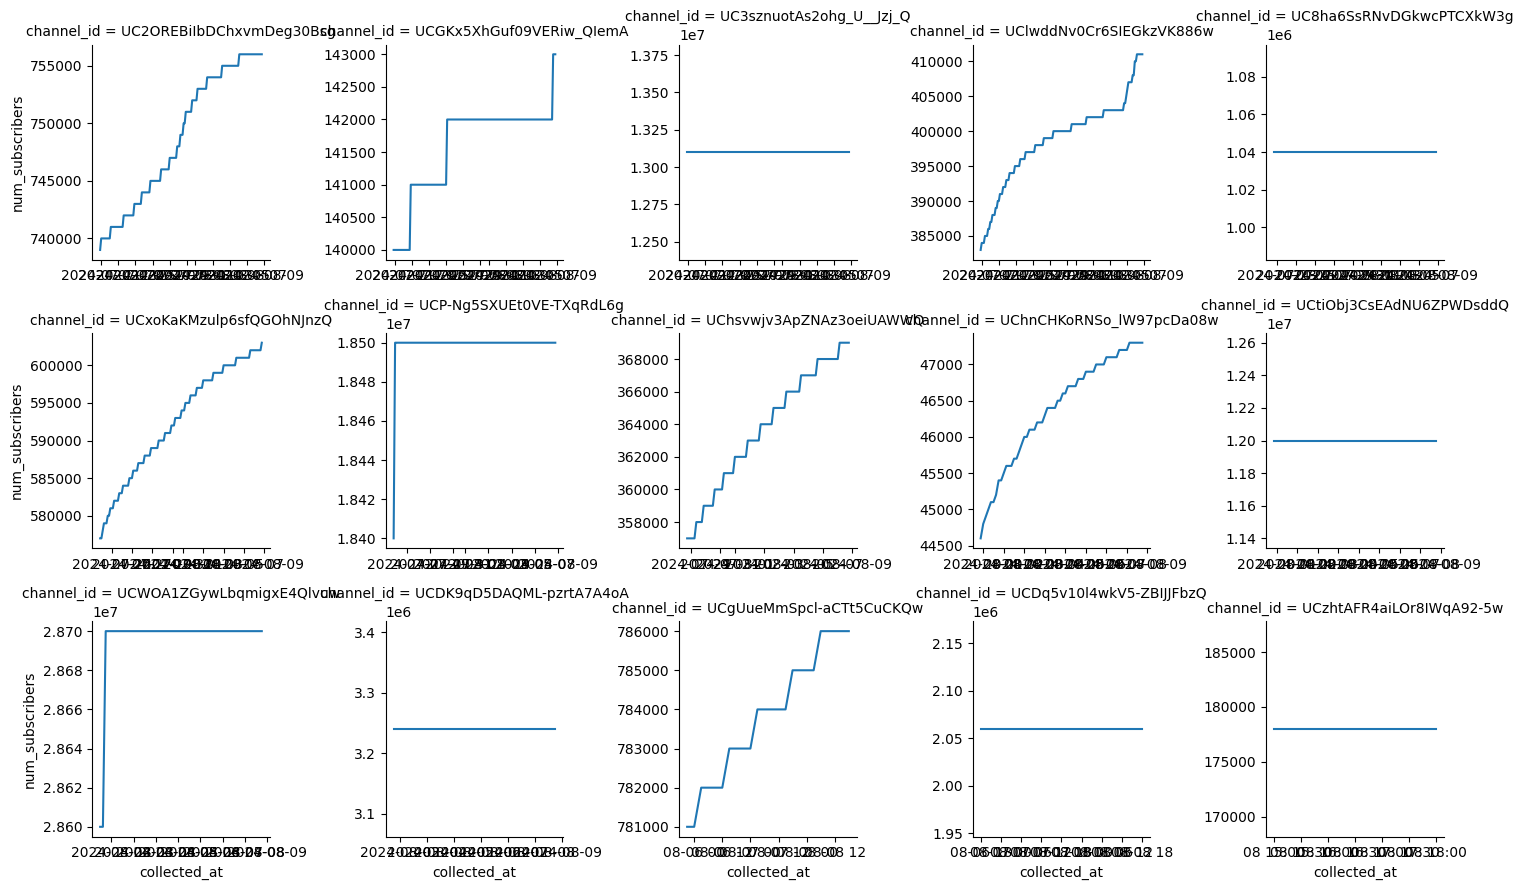

In [30]:
col = "num_subscribers"
id_data = channel_fact.loc[channel_fact["channel_id"].isin(ids), ["channel_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="channel_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

### num_videos

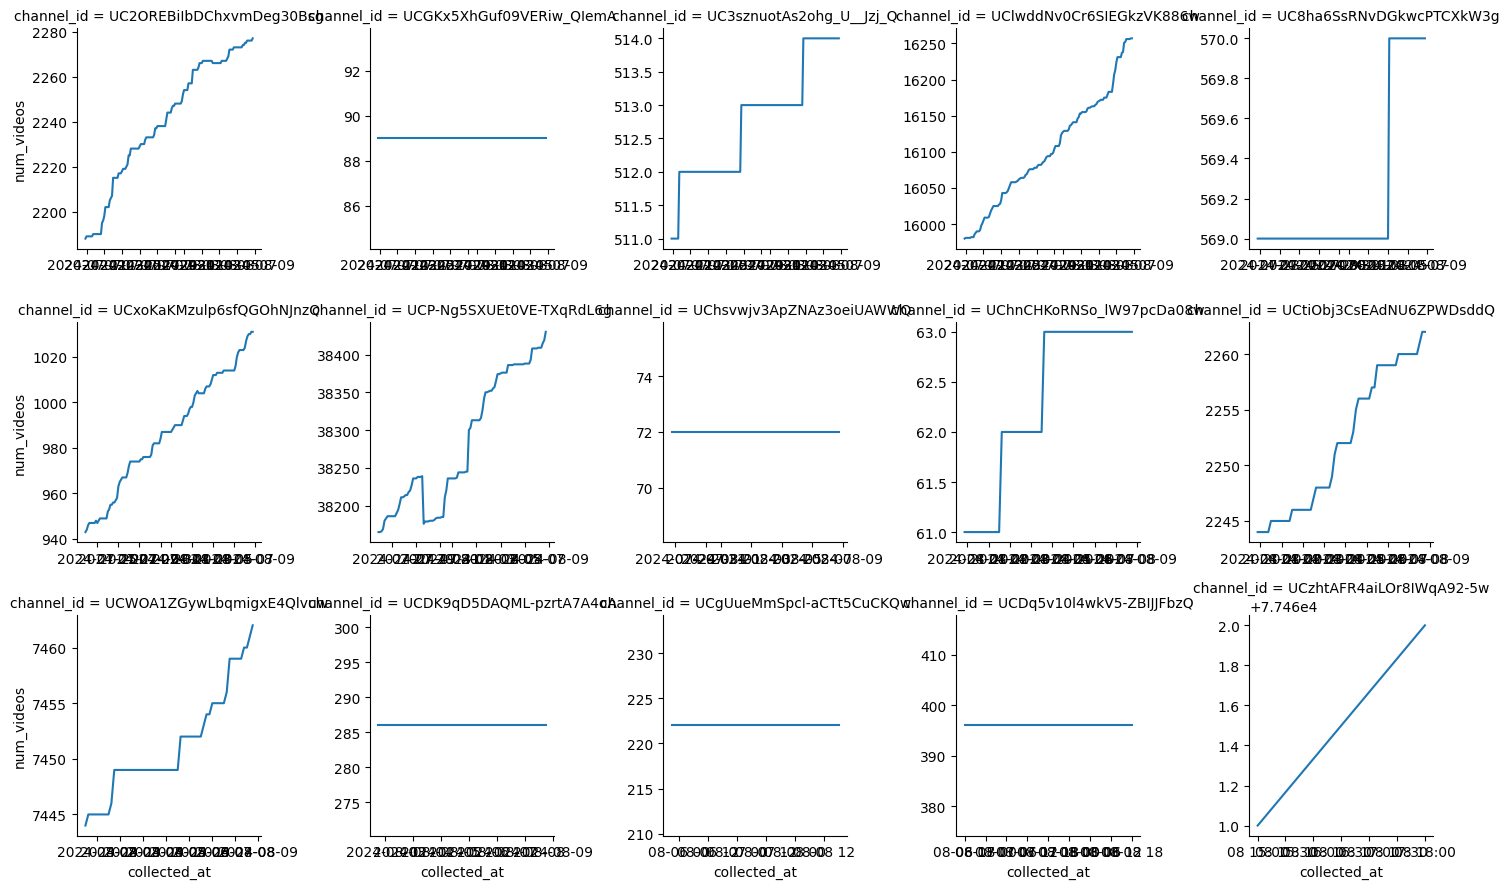

In [31]:
col = "num_videos"
id_data = channel_fact.loc[channel_fact["channel_id"].isin(ids), ["channel_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="channel_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

## video_dim

In [32]:
video_dim.shape

(806, 10)

In [33]:
video_dim.dtypes

video_id                     object
channel_id                   object
video_title                  object
video_description            object
num_tags                      int64
duration_seconds              int64
licensed_content               bool
made_for_kids                  bool
published_at         datetime64[ns]
category_id                   int64
dtype: object

In [34]:
video_dim.describe()

,num_tags,duration_seconds,published_at,category_id
count,806.000000,806.000000,806,806.000000
mean,16.042184,961.006203,2024-07-26 08:26:26.569478912,18.589330
min,0.000000,22.000000,2024-06-26 12:22:40,1.000000
25%,4.000000,203.000000,2024-07-19 22:07:11.500000,17.000000
50%,15.000000,632.000000,2024-07-26 13:15:40.500000,20.000000
75%,25.000000,1406.750000,2024-08-01 17:13:06.249999872,24.000000
max,64.000000,13311.000000,2024-08-08 10:01:09,28.000000
std,13.046052,1038.203311,NaN,6.507623


### video_id

In [35]:
video_dim["video_id"].sample(15)

352    xIoP_mhYRT0
575    kIUAWe9ThRA
155    6bfOkxA3lWs
354    1F35OVbmyU0
144    8kTlL0ycgyQ
296    2qnLMkG_dNM
522    93nFkNBbgaI
384    nEP-_Ogi1bA
39     dOWUh9Ja4oM
445    IPb9Hrp3KIw
371    YbDzBpILqNY
454    _-1mC6CyEek
800    SUtpk6c7GTw
238    tuwQxcL8wjQ
565    ulvCwyKrwqw
Name: video_id, dtype: object

In [36]:
video_dim["video_id"].apply(lambda x: len(x)).value_counts()

video_id
11    806
Name: count, dtype: int64

### video_title

In [37]:
video_dim["video_title"].sample(15)

232                                  Incredible Cat Tech
12       The New Lethal Company Update is Out of Control
291    Shannon Sharpe reacts to Skip Bayless leaving ...
181    Australia vs. United States Highlights | USA B...
625                                      Trying Erewhon!
570    Team USA men’s basketball BLASTS past South Su...
392                      Halsey - Lucky (Official Video)
16     I Played the NEW 1.21 Update in Minecraft Hard...
719                           Debby Might Loop Around...
667    Julien Alfred BEATS Sha'Carri Richardson to wi...
149    NEW Ugarte BID! Neves Transfer HIJACK? Yoro An...
400                 Ice Spice, Travis Scott - Oh Shhh...
805    A NEW WEEK🤍 | HORSE RIDING, NEW CARS, EXCITING...
379    Punt Gun vs Bulletproof Glass (200,000 FPS ft....
567     Surprising My Crush with 1,000 Gifts in 24 Hours
Name: video_title, dtype: object

In [38]:
video_dim["video_title"].apply(lambda x: len(x)).value_counts()

video_title
49    29
43    23
42    22
45    19
58    18
      ..
84     2
7      1
4      1
86     1
88     1
Name: count, Length: 93, dtype: int64

### video_description

In [39]:
video_dim["video_description"].sample(15)

520              they're calling this the concord killer
114    iOS 18. Coming soon to an iPhone near you.\n\n...
119    Solid State Batteries Are REALLY Here: Yoshino...
79     Team Colin Vs Team Owen compete in a race to s...
95     Get in the ring for Season 5 on July 24 💪 \n\n...
805    Thank you for watching guys and for your patie...
608    20 years after her 2005 win, home-grown supers...
93     Sean takes a deep dive into Worlds Part I, the...
761    To see the future sometimes you need to unders...
386    Listen To Work Of Art ft Russ: https://willsmi...
611    Bobby Carter | August 2, 2024\nExperience with...
133    Shakira performed “Hips Don’t Lie” / “Te Felic...
186    Stream // Download Ice Spice & Central Cee's "...
690    Welcome to Hermitcraft Season 10 - Episode 22!...
33     After my very lacklustre visit in 2022, I conc...
Name: video_description, dtype: object

In [40]:
video_dim["video_description"].apply(lambda x: len(x)).value_counts()

video_description
0       4
598     4
497     4
485     4
555     4
       ..
1463    1
933     1
42      1
393     1
741     1
Name: count, Length: 664, dtype: int64

### num_tags

<Axes: xlabel='num_tags', ylabel='Count'>

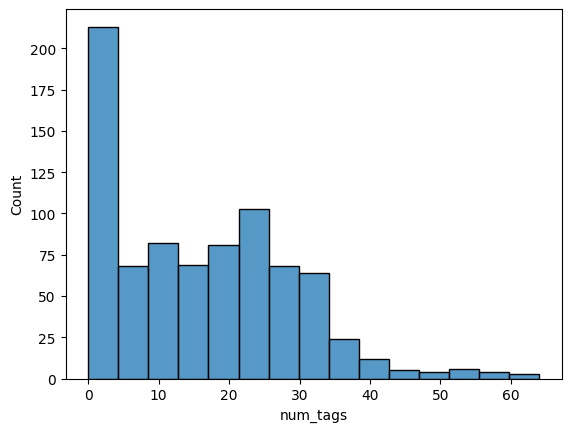

In [41]:
sns.histplot(video_dim, x="num_tags")

### duration_seconds

<Axes: xlabel='duration_seconds', ylabel='Count'>

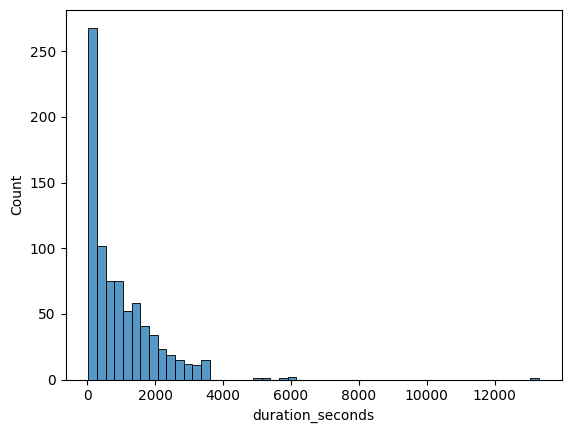

In [42]:
sns.histplot(video_dim, x="duration_seconds")

### licensed_content

In [43]:
video_dim["licensed_content"].value_counts()

licensed_content
True     737
False     69
Name: count, dtype: int64

### made_for_kids

In [44]:
video_dim["made_for_kids"].value_counts()

made_for_kids
False    804
True       2
Name: count, dtype: int64

### published_at

<Axes: xlabel='published_at', ylabel='Count'>

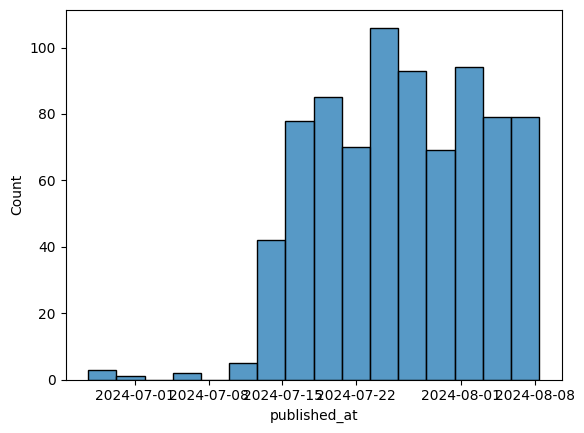

In [45]:
sns.histplot(video_dim, x="published_at")

### category_id

In [46]:
video_dim["category_id"].value_counts()

category_id
20    175
24    150
17    148
10    101
22     70
25     43
1      28
2      25
23     22
28     18
26     12
27     10
19      3
15      1
Name: count, dtype: int64

## channel_dim

In [47]:
channel_dim.shape

(607, 3)

In [48]:
channel_dim.dtypes

channel_id                  object
channel_name                object
created_datetime    datetime64[ns]
dtype: object

In [49]:
channel_dim.describe()

,created_datetime
count,607
mean,2014-06-16 21:18:55.552561152
min,2005-06-16 12:09:27
25%,2010-05-16 01:57:48.500000
50%,2014-08-04 03:08:41
75%,2018-07-31 21:41:48
max,2024-07-19 21:40:21.622480


### channel_id

In [50]:
channel_dim["channel_id"].sample(15)

161    UCMmVPVb0BwSIOWVeDwlPocQ
83     UCsAPiUMyBjtKamxYGbSUnLA
174    UCIr2L5vnVPAC1-FCLf5mcng
286    UCor9rW6PgxSQ9vUPWQdnaYQ
526    UCY8ypPJgfJqeYTtFEDyqCyw
350    UCLc_ZQgQ8h2XKUAQpqcvIdw
511    UCu6v4AdYxVH5fhfq9mi5llA
100    UC3jFoA7_6BTV90hsRSVHoaw
67     UCK5cUXncI7unTWJGjRjN8gQ
319    UCWUxsoGia86OYIbxhjg68WQ
439    UC8DlzSaYnLh1TT40sBkUtFg
448    UC9ek8xUVjnmQ-q7f6CTwtxg
482    UCXuqSBlHAE6Xw-yeJA0Tunw
209    UCq4qiifOaFGW3a2oljSfxUg
529    UC-RxXi2Xws6Uk22vp-sLbGA
Name: channel_id, dtype: object

In [51]:
channel_dim["channel_id"].apply(lambda x: len(x)).value_counts()

channel_id
24    607
Name: count, dtype: int64

### channel_name

In [52]:
channel_dim["channel_name"].sample(15)

100    Phil Mickelson and the HyFlyers
490                             Shroud
309                       Matthew Beem
54                           GQ Sports
486                           StarTalk
180                   Nintendo 公式チャンネル
548                         Forge Labs
35                            Sean Rii
491                        Chris Dixon
239                      Gordon Ramsay
277                Bloomberg Originals
115                TheColumbusDispatch
327                          Chevrolet
62              Technology Connections
438                             Foltyn
Name: channel_name, dtype: object

In [53]:
channel_dim["channel_name"].apply(lambda x: len(x)).value_counts()

channel_name
10    53
12    50
13    46
14    45
11    45
15    38
7     37
8     34
17    30
16    29
9     29
5     27
19    20
6     20
18    17
3     17
4     13
20    13
24     7
21     6
22     6
26     5
23     4
25     3
31     2
27     2
34     2
2      2
38     1
28     1
50     1
37     1
36     1
Name: count, dtype: int64

### created_datetime

<Axes: xlabel='created_datetime', ylabel='Count'>

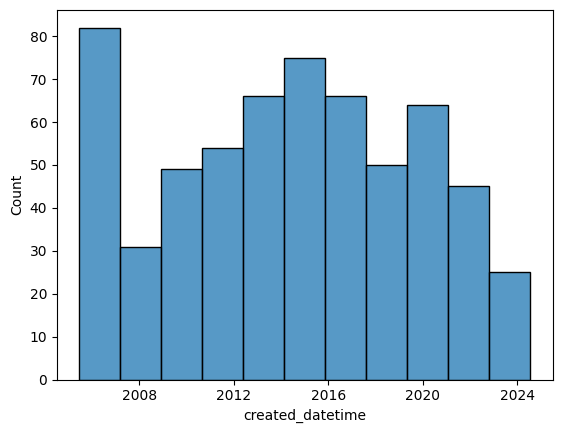

In [54]:
sns.histplot(channel_dim, x="created_datetime")

## categories_dim

In [55]:
print(categories_dim)

    category_id          category_name
0             1       Film & Animation
1             2       Autos & Vehicles
2            10                  Music
3            15         Pets & Animals
4            17                 Sports
5            18           Short Movies
6            19        Travel & Events
7            20                 Gaming
8            21          Videoblogging
9            22         People & Blogs
10           23                 Comedy
11           24          Entertainment
12           25        News & Politics
13           26          Howto & Style
14           27              Education
15           28   Science & Technology
16           29  Nonprofits & Activism
17           30                 Movies
18           31        Anime/Animation
19           32       Action/Adventure
20           33               Classics
21           34                 Comedy
22           35            Documentary
23           36                  Drama
24           37          

# Data Preparation
## Combine video_fact, video_dim, and categories_dim

In [95]:
video_all = (video_fact.merge(video_dim, on="video_id", how="inner")
             .merge(categories_dim, on="category_id", how="inner"))

((76640, 15),
 Index(['collected_at', 'video_id', 'num_views', 'num_likes', 'num_comments',
        'channel_id', 'video_title', 'video_description', 'num_tags',
        'duration_seconds', 'licensed_content', 'made_for_kids', 'published_at',
        'category_id', 'category_name'],
       dtype='object'))

In [97]:
video_all.rename(columns={"collected_at":"video_collected_at", "published_at":"video_published_at"}, inplace=True)

In [98]:
video_all.shape, video_all.columns

((76640, 15),
 Index(['video_collected_at', 'video_id', 'num_views', 'num_likes',
        'num_comments', 'channel_id', 'video_title', 'video_description',
        'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
        'video_published_at', 'category_id', 'category_name'],
       dtype='object'))

In [150]:
video_all["hours_since_published"] = (video_all["video_published_at"] - video_all["video_collected_at"])/pd.Timedelta("-1d")
video_all["hours_since_published"]

0         1.294111
1         1.419107
2         1.544103
3         1.669111
4         1.794106
           ...    
76635    13.450757
76636    13.575764
76637    13.700767
76638    13.825760
76639    13.950761
Name: hours_since_published, Length: 76640, dtype: float64

## Combine channel_fact and channel_dim

In [96]:
channel_all = channel_fact.merge(channel_dim, on="channel_id", how="inner")

((62443, 7),
 Index(['collected_at', 'channel_id', 'channel_total_views', 'num_subscribers',
        'num_videos', 'channel_name', 'created_datetime'],
       dtype='object'))

In [99]:
channel_all.rename(columns={"collected_at":"channel_collected_at", 
                            "created_datetime":"channel_created_at",
                            "num_videos":"channel_num_videos"}, inplace=True)

In [100]:
channel_all.shape, channel_all.columns

((62443, 7),
 Index(['channel_collected_at', 'channel_id', 'channel_total_views',
        'num_subscribers', 'channel_num_videos', 'channel_name',
        'channel_created_at'],
       dtype='object'))

In [149]:
channel_all["channel_days_since_created"] = (channel_all["channel_created_at"] - channel_all["channel_collected_at"])/pd.Timedelta("-1d")
channel_all["channel_days_since_created"]

0         667.307010
1         667.432007
2         667.557003
3         667.682011
4         667.807006
            ...     
62438    5883.799435
62439    5904.411438
62440    2551.019794
62441    3378.313787
62442    3095.819053
Name: channel_days_since_created, Length: 62443, dtype: float64

## Get snapshots of all tables at their first time points, one day after their first time points, and one week after their first time points.
Data are sampled 8x per day (every 3 hours).

### First time point for each video and corresponding channel and category data

In [153]:
vid_first = video_all.groupby("video_id").nth(0)
vid_first.shape, vid_first.head()

((806, 16),
             video_collected_at     video_id  num_views  num_likes  \
 0   2024-07-20 21:00:06.211863  laNA2HgwYXU    7023341     334132   
 152 2024-07-20 21:00:06.211863  u_as_PygtDc    1022746      46145   
 304 2024-07-20 21:00:06.211863  Qn1UJssT-mU   13106958     716571   
 456 2024-07-20 21:00:06.211863  H-c1bAk9Soc     535473      25595   
 
      num_comments                channel_id  \
 0           16936  UCA3-nIYWu4PTWkb6NwhEpzg   
 152          4234  UCGTKwjs1ctvgwCRa67RNO-Q   
 304         57805  UCsSsgPaZ2GSmO6il8Cb5iGA   
 456          1943  UCOgGAfSUy5LvEyVS_LF5kdw   
 
                                            video_title  \
 0                 Deadpool & Wolverine | Final Trailer   
 152  Uh Oh…My Boaterhome Might Actually Be a BUMMER...   
 304                         skibidi toilet 76 (part 2)   
 456                     Brits try Texas Ballpark food!   
 
                                      video_description  num_tags  \
 0    This isn’t the movie y

In [154]:
ch_first = channel_all.groupby("channel_id").nth(0)
ch_first.head(), ch_first.shape

(          channel_collected_at                channel_id  channel_total_views  \
 0   2024-07-20 21:00:07.479465  UC2OREBiIbDChxvmDeg30Bsg            146866146   
 152 2024-07-20 21:00:07.479465  UCqJIIqwYgqN0BUuk8Iea2yg               562521   
 304 2024-07-20 21:00:07.479465  UCFuzExfO2fUVmNK5_COvsNg            299845403   
 456 2024-07-20 21:00:07.479465  UCVV9-BZ_8EybNWtbvnF8DHw             17570232   
 608 2024-07-20 21:00:07.479465  UCftwRNsjfRo08xYE31tkiyw           4127130008   
 
      num_subscribers  channel_num_videos            channel_name  \
 0             739000                2188        Stephen A. Smith   
 152              321                   1                JADEVEVO   
 304           345000               44986  8 News Now — Las Vegas   
 456           295000                 582         Love Island USA   
 608         11300000                3890                   WIRED   
 
             channel_created_at  channel_days_since_created  
 0   2022-09-22 13:38:01.837

In [155]:
all_first = vid_first.merge(ch_first, on="channel_id", how="left")

In [214]:
all_first.shape, all_first.columns

((806, 23),
 Index(['video_collected_at', 'video_id', 'num_views', 'num_likes',
        'num_comments', 'channel_id', 'video_title', 'video_description',
        'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
        'video_published_at', 'category_id', 'category_name',
        'hours_since_published', 'channel_collected_at', 'channel_total_views',
        'num_subscribers', 'channel_num_videos', 'channel_name',
        'channel_created_at', 'channel_days_since_created'],
       dtype='object'))

In [215]:
all_first.to_csv("all_first.csv")

### One day after first time point for each video  and corresponding channel and category data

In [157]:
vid_1day = video_all.groupby("video_id").nth(8)
vid_1day.head(), vid_1day.shape

(            video_collected_at     video_id  num_views  num_likes  \
 8   2024-07-21 21:00:05.719201  laNA2HgwYXU    8615067     363859   
 160 2024-07-21 21:00:05.719201  u_as_PygtDc    1387795      54569   
 312 2024-07-21 21:00:05.719201  Qn1UJssT-mU   14409552     738857   
 464 2024-07-21 21:00:05.719201  H-c1bAk9Soc     671950      29551   
 616 2024-07-21 21:00:05.719201  7Nk5C6o3PkQ    2621584     115550   
 
      num_comments                channel_id  \
 8           17933  UCA3-nIYWu4PTWkb6NwhEpzg   
 160          5031  UCGTKwjs1ctvgwCRa67RNO-Q   
 312         58807  UCsSsgPaZ2GSmO6il8Cb5iGA   
 464          2178  UCOgGAfSUy5LvEyVS_LF5kdw   
 616          4601  UCPD_bxCRGpmmeQcbe2kpPaA   
 
                                            video_title  \
 8                 Deadpool & Wolverine | Final Trailer   
 160  Uh Oh…My Boaterhome Might Actually Be a BUMMER...   
 312                         skibidi toilet 76 (part 2)   
 464                     Brits try Texas Ballpark fo

In [158]:
ch_1day = channel_all.groupby("channel_id").nth(8)
ch_1day.head(), ch_1day.shape

(          channel_collected_at                channel_id  channel_total_views  \
 8   2024-07-21 21:00:07.179999  UC2OREBiIbDChxvmDeg30Bsg            147649149   
 160 2024-07-21 21:00:07.179999  UCqJIIqwYgqN0BUuk8Iea2yg              1356381   
 312 2024-07-21 21:00:07.179999  UCFuzExfO2fUVmNK5_COvsNg            300006823   
 464 2024-07-21 21:00:07.179999  UCVV9-BZ_8EybNWtbvnF8DHw             17739280   
 616 2024-07-21 21:00:07.179999  UCftwRNsjfRo08xYE31tkiyw           4128653009   
 
      num_subscribers  channel_num_videos            channel_name  \
 8             740000                2190        Stephen A. Smith   
 160              332                   1                JADEVEVO   
 312           345000               44987  8 News Now — Las Vegas   
 464           295000                 584         Love Island USA   
 616         11300000                3890                   WIRED   
 
             channel_created_at  channel_days_since_created  
 8   2022-09-22 13:38:01.837

In [159]:
all_1day = vid_1day.merge(ch_1day, on="channel_id", how="left")

In [213]:
all_1day.shape, all_1day.columns

((778, 23),
 Index(['video_collected_at', 'video_id', 'num_views', 'num_likes',
        'num_comments', 'channel_id', 'video_title', 'video_description',
        'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
        'video_published_at', 'category_id', 'category_name',
        'hours_since_published', 'channel_collected_at', 'channel_total_views',
        'num_subscribers', 'channel_num_videos', 'channel_name',
        'channel_created_at', 'channel_days_since_created'],
       dtype='object'))

In [216]:
all_1day.to_csv("all_1day.csv")

### One week after each time point for each video and corresponding channel and category data

In [161]:
vid_1week = video_all.groupby("video_id").nth(56)
vid_1week

,video_collected_at,video_id,num_views,num_likes,num_comments,channel_id,video_title,video_description,num_tags,duration_seconds,licensed_content,made_for_kids,video_published_at,category_id,category_name,hours_since_published
56,2024-07-27 21:00:05.811850,laNA2HgwYXU,10178441,404423,18802,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,False,False,2024-07-19 13:56:35,24,Entertainment,8.294107
208,2024-07-27 21:00:05.811850,u_as_PygtDc,2019230,70374,6578,UCGTKwjs1ctvgwCRa67RNO-Q,Uh Oh…My Boaterhome Might Actually Be a BUMMER...,Thanks to ARMRA Colostrum for sponsoring this ...,44,1657,True,False,2024-07-19 22:28:07,24,Entertainment,7.938875
360,2024-07-27 21:00:05.811850,Qn1UJssT-mU,16876175,780063,60523,UCsSsgPaZ2GSmO6il8Cb5iGA,skibidi toilet 76 (part 2),cameramen attempt to escape city\n\nfull-scree...,7,268,True,False,2024-07-19 05:00:22,24,Entertainment,8.666479
512,2024-07-27 21:00:05.811850,H-c1bAk9Soc,904825,36447,2624,UCOgGAfSUy5LvEyVS_LF5kdw,Brits try Texas Ballpark food!,"Get 4 months extra on a 2 year plan, plus up t...",63,876,True,False,2024-07-19 15:30:31,24,Entertainment,8.228875
664,2024-07-27 21:00:05.811850,7Nk5C6o3PkQ,3473190,144126,5234,UCPD_bxCRGpmmeQcbe2kpPaA,Childish Gambino Goes On a Vision Quest While ...,"Donald Glover—a.k.a., Childish Gambino—is a fi...",25,1393,True,False,2024-07-18 15:00:11,24,Entertainment,9.249940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76094,2024-08-08 18:00:05.781603,EiK9kfO_qqA,1030087,37767,1089,UChRlaISXbl2gECFAmDzxgzg,Daily Driving My Tank After Giving it a 1000HP...,Love tanks too?? Check out World of Tanks and ...,0,1475,True,False,2024-07-31 18:12:29,2,Autos & Vehicles,7.991398
76279,2024-07-27 21:00:05.811850,uQ8yDdtoFj0,1106033,34921,1882,UC4ijq8Cg-8zQKx8OH12dUSw,What's Inside California's Craziest Airbnbs?,Joshua Tree has the most unique airbnbs!! For ...,25,1958,True,False,2024-07-13 15:00:53,19,Travel & Events,14.249454
76431,2024-08-04 00:00:05.801973,KQFMB-Mf1LA,1164978,43721,3959,UC4ijq8Cg-8zQKx8OH12dUSw,Back to Van Life + a big announcement!,We’re back in our van for the summer!! In this...,19,2312,True,False,2024-07-27 15:00:17,19,Travel & Events,7.374870
76526,2024-08-07 21:00:05.578715,1eafBVGTJQ8,767587,16382,1199,UCGl3kbSLHfKb3QeOYG7pAuA,Introducing The Wizarding World of Harry Potte...,Explore the wonders of The Wizarding World of ...,29,377,False,False,2024-07-31 12:30:42,19,Travel & Events,7.353745


In [162]:
ch_1week = channel_all.groupby("channel_id").nth(56)
ch_1week

,channel_collected_at,channel_id,channel_total_views,num_subscribers,channel_num_videos,channel_name,channel_created_at,channel_days_since_created
56,2024-07-27 21:00:07.899199,UC2OREBiIbDChxvmDeg30Bsg,150014889,745000,2233,Stephen A. Smith,2022-09-22 13:38:01.837628,674.307015
208,2024-07-27 21:00:07.899199,UCqJIIqwYgqN0BUuk8Iea2yg,3448900,569,1,JADEVEVO,2009-05-12 05:28:12.000000,5555.647175
360,2024-07-27 21:00:07.899199,UCFuzExfO2fUVmNK5_COvsNg,301189522,346000,45037,8 News Now — Las Vegas,2015-11-11 22:04:13.000000,3180.955497
512,2024-07-27 21:00:07.899199,UCVV9-BZ_8EybNWtbvnF8DHw,18516541,297000,584,Love Island USA,2019-04-24 16:19:10.000000,1921.195115
664,2024-07-27 21:00:07.899199,UCftwRNsjfRo08xYE31tkiyw,4137371992,11400000,3893,WIRED,2005-09-23 03:09:26.000000,6882.743540
...,...,...,...,...,...,...,...,...
58574,2024-08-08 18:00:09.212975,UCmdsVknXGS2145yy8eQvplw,128576791,5580,39,ShaboozeyVEVO,2017-11-07 17:09:06.000000,2466.035454
58631,2024-08-08 18:00:09.212975,UCJRz6HSllkQKmFxaPk8IViw,156054976,574000,804,"BFFs: Dave Portnoy, Josh Richards & Bri Chicke...",2020-10-12 16:37:04.815482,1396.057690
58688,2024-08-08 18:00:09.212975,UClu2e7S8atp6tG2galK9hgg,494412673,1940000,3890,BdoubleO100,2011-04-20 02:50:52.000000,4859.631449
58745,2024-08-08 18:00:09.212975,UChRlaISXbl2gECFAmDzxgzg,323933278,3560000,174,Westen Champlin,2010-03-17 03:38:35.000000,5258.598313


In [163]:
all_1week = vid_1week.merge(ch_1week, on="channel_id", how="left")

In [212]:
all_1week.shape, all_1week.columns

((588, 23),
 Index(['video_collected_at', 'video_id', 'num_views', 'num_likes',
        'num_comments', 'channel_id', 'video_title', 'video_description',
        'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
        'video_published_at', 'category_id', 'category_name',
        'hours_since_published', 'channel_collected_at', 'channel_total_views',
        'num_subscribers', 'channel_num_videos', 'channel_name',
        'channel_created_at', 'channel_days_since_created'],
       dtype='object'))

In [217]:
all_1week.to_csv("all_1week.csv")

# Questions

## How well does a video need to do to show up on "most popular"?

In [165]:
all_first.columns

Index(['video_collected_at', 'video_id', 'num_views', 'num_likes',
       'num_comments', 'channel_id', 'video_title', 'video_description',
       'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
       'video_published_at', 'category_id', 'category_name',
       'hours_since_published', 'channel_collected_at', 'channel_total_views',
       'num_subscribers', 'channel_num_videos', 'channel_name',
       'channel_created_at', 'channel_days_since_created'],
      dtype='object')

In [166]:
cols = ["num_views", "num_likes", "num_comments", "num_tags", "duration_seconds", "hours_since_published"]
all_first[cols].describe().apply(lambda x: x.apply('{0:.5f}'.format)) # gets rid of scientific notation

,num_views,num_likes,num_comments,num_tags,duration_seconds,hours_since_published
count,806.00000,806.00000,806.00000,806.00000,806.00000,806.00000
mean,1419208.54094,71156.27543,4995.32382,16.04218,961.00620,1.60882
std,7349534.09404,391642.76110,20865.71424,13.04605,1038.20331,2.42693
min,30340.00000,0.00000,0.00000,0.00000,22.00000,0.08270
25%,224918.75000,8302.75000,732.75000,4.00000,203.00000,0.48640
50%,432569.50000,17983.00000,1608.00000,15.00000,632.00000,0.83331
75%,910457.00000,44210.50000,3469.75000,25.00000,1406.75000,1.22905
max,159559695.00000,7392365.00000,337068.00000,64.00000,13311.00000,24.35933


- The least viewed video had 30k views and the most viewed had 159 million before it was "most popular"
- Some "most popular" videos have no likes, no comments, and/or no tags.
- Videos can be as few as 22 seconds long or as many as 13000 seconds long (3.6 hrs)
- 75% of videos that show up on most popular have been out for less than 30 hours.

In [167]:
melted = all_first[cols].melt(var_name="column")
melted.sample(5)

,column,value
4464,hours_since_published,0.500020
3434,duration_seconds,121.000000
501,num_views,252377.000000
4633,hours_since_published,0.416662
1061,num_likes,29583.000000


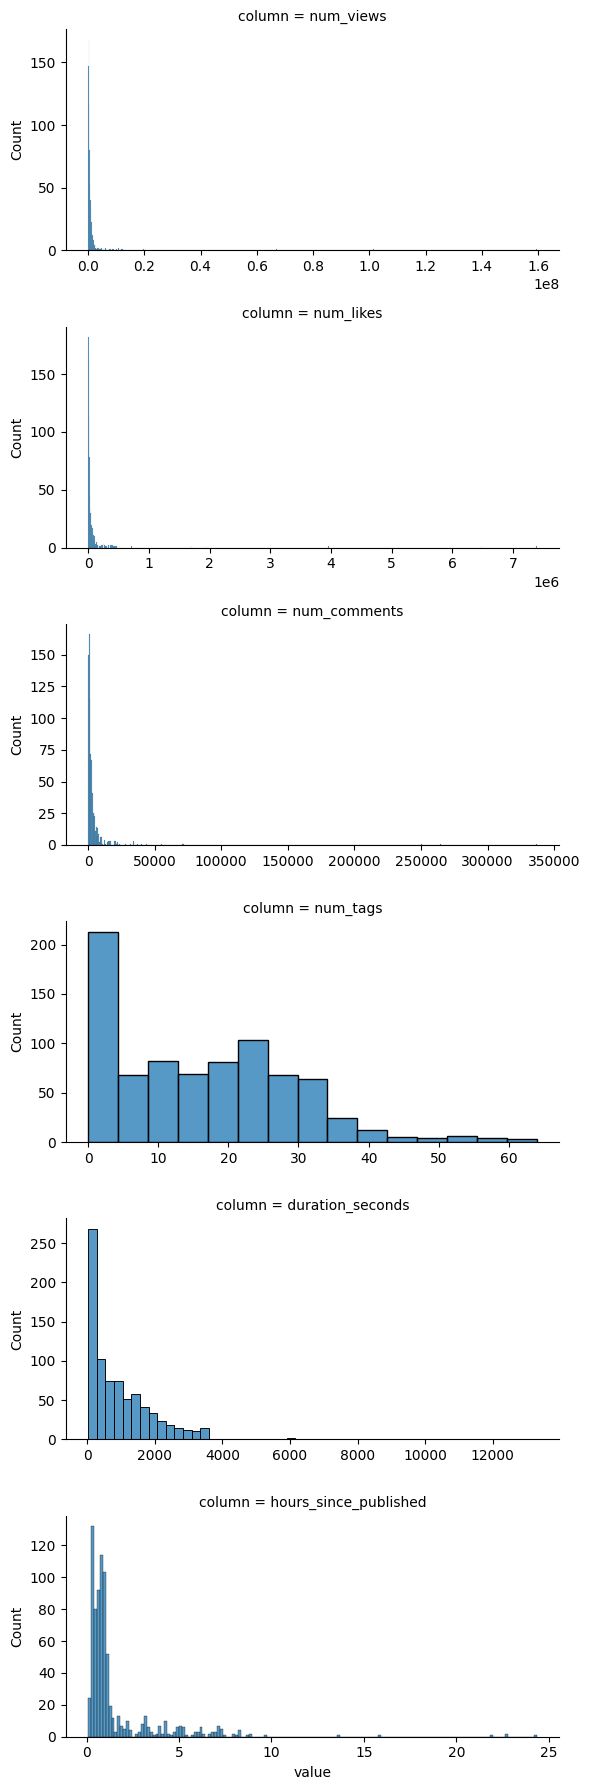

In [168]:
g = sns.FacetGrid(melted, row="column", sharey=False, sharex=False, aspect=2)
g.map_dataframe(sns.histplot, "value")

There are many outliers for views and comments and likes.

In [229]:
no_views = all_first.loc[all_first["num_views"] == 0]
no_views.shape[0]/all_first.shape[0] * 100

0.0

In [169]:
# how many videos have 0 likes, comments, or tags?
no_comments = all_first.loc[all_first["num_comments"] == 0]
no_comments.shape[0]/all_first.shape[0] * 100

2.109181141439206

2% of videos have comments disabled

In [170]:
no_tags = all_first.loc[all_first["num_tags"] == 0]
no_tags.shape[0]/all_first.shape[0] * 100

16.997518610421835

17% of videos have no tags

In [171]:
no_likes = all_first.loc[all_first["num_likes"] == 0]
no_likes.shape[0]/all_first.shape[0] * 100

0.37220843672456577

.4% of videos have likes hidden

In [172]:
corr_cols = cols + ['made_for_kids', 'licensed_content']

<Axes: >

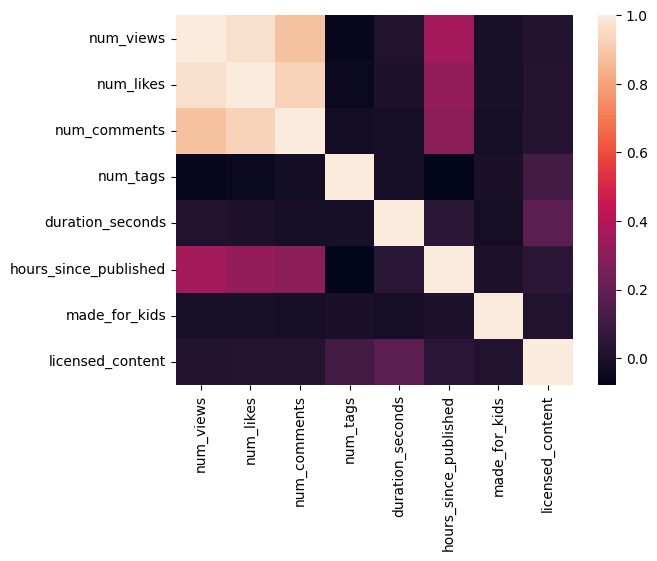

In [173]:
sns.heatmap(all_first[corr_cols].corr())

Views, likes, and comments are correlated, and there's a slight correlation between the video being out for longer and having more likes, views, and comments. Not surprising. The other variables seem to have no effect on views.

### Conclusion
There doesn't seem to be any specific level of performance for videos to show up on most popular. It's hard to even answer this question because I don't have any information on what the videos' stats looked like before they were on most popular.

## How much do views grow after one day and one week?
### One day growth

In [174]:
all_1day.shape

(778, 23)

In [175]:
growth_1day = all_first[["video_id", "num_views"]].merge(all_1day[["video_id", "num_views"]],
                                                         on="video_id", 
                                                         how="inner", 
                                                         suffixes=("_first", "_1day"))
growth_1day

,video_id,num_views_first,num_views_1day
0,laNA2HgwYXU,7023341,8615067
1,u_as_PygtDc,1022746,1387795
2,Qn1UJssT-mU,13106958,14409552
3,H-c1bAk9Soc,535473,671950
4,7Nk5C6o3PkQ,2272245,2621584
...,...,...,...
773,0luAzyPl7DI,207844,275978
774,uQ8yDdtoFj0,894317,940508
775,KQFMB-Mf1LA,296079,717963
776,1eafBVGTJQ8,114218,280084


In [176]:
growth_1day["abs_growth"] = growth_1day["num_views_1day"] - growth_1day["num_views_first"]
growth_1day["pct_growth"] = growth_1day["abs_growth"] / growth_1day["num_views_first"]
growth_1day

,video_id,num_views_first,num_views_1day,abs_growth,pct_growth
0,laNA2HgwYXU,7023341,8615067,1591726,0.226634
1,u_as_PygtDc,1022746,1387795,365049,0.356930
2,Qn1UJssT-mU,13106958,14409552,1302594,0.099382
3,H-c1bAk9Soc,535473,671950,136477,0.254872
4,7Nk5C6o3PkQ,2272245,2621584,349339,0.153742
...,...,...,...,...,...
773,0luAzyPl7DI,207844,275978,68134,0.327813
774,uQ8yDdtoFj0,894317,940508,46191,0.051649
775,KQFMB-Mf1LA,296079,717963,421884,1.424903
776,1eafBVGTJQ8,114218,280084,165866,1.452188


In [177]:
growth_1day.describe().apply(lambda x: x.apply('{0:.5f}'.format)) # gets rid of scientific notation

,num_views_first,num_views_1day,abs_growth,pct_growth
count,778.00000,778.00000,778.00000,778.00000
mean,1454805.80977,1902443.47172,447637.66195,0.67925
std,7478072.10631,8164653.19708,1858362.43690,0.93852
min,30340.00000,45072.00000,138.00000,0.00009
25%,225844.75000,353407.25000,78187.75000,0.19469
50%,439060.00000,671325.50000,165676.50000,0.41686
75%,934193.75000,1346362.25000,389763.00000,0.84132
max,159559695.00000,164670475.00000,48086405.00000,12.69989


After becoming most popular, videos grow by 447 thousand +/- 1.8 million in one day

### One week growth

In [178]:
all_1week.shape

(588, 23)

In [179]:
growth_1week = all_first[["video_id", "num_views"]].merge(all_1week[["video_id", "num_views"]],
                                                         on="video_id", 
                                                         how="inner", 
                                                         suffixes=("_first", "_1day"))
growth_1week

,video_id,num_views_first,num_views_1day
0,laNA2HgwYXU,7023341,10178441
1,u_as_PygtDc,1022746,2019230
2,Qn1UJssT-mU,13106958,16876175
3,H-c1bAk9Soc,535473,904825
4,7Nk5C6o3PkQ,2272245,3473190
...,...,...,...
583,EiK9kfO_qqA,439892,1030087
584,uQ8yDdtoFj0,894317,1106033
585,KQFMB-Mf1LA,296079,1164978
586,1eafBVGTJQ8,114218,767587


In [180]:
growth_1week["abs_growth"] = growth_1week["num_views_1day"] - growth_1week["num_views_first"]
growth_1week["pct_growth"] = growth_1week["abs_growth"] / growth_1week["num_views_first"]
growth_1week

,video_id,num_views_first,num_views_1day,abs_growth,pct_growth
0,laNA2HgwYXU,7023341,10178441,3155100,0.449231
1,u_as_PygtDc,1022746,2019230,996484,0.974322
2,Qn1UJssT-mU,13106958,16876175,3769217,0.287574
3,H-c1bAk9Soc,535473,904825,369352,0.689768
4,7Nk5C6o3PkQ,2272245,3473190,1200945,0.528528
...,...,...,...,...,...
583,EiK9kfO_qqA,439892,1030087,590195,1.341682
584,uQ8yDdtoFj0,894317,1106033,211716,0.236735
585,KQFMB-Mf1LA,296079,1164978,868899,2.934686
586,1eafBVGTJQ8,114218,767587,653369,5.720368


In [181]:
growth_1week.describe().apply(lambda x: x.apply('{0:.5f}'.format)) # gets rid of scientific notation

,num_views_first,num_views_1day,abs_growth,pct_growth
count,588.00000,588.00000,588.00000,588.00000
mean,1648886.97789,2799600.18197,1150713.20408,1.80274
std,8460445.14096,10374818.40025,2718053.68653,3.01070
min,30340.00000,81168.00000,-30232.00000,-0.08771
25%,230312.00000,547726.50000,184794.25000,0.39412
50%,463651.00000,1048661.50000,449693.00000,1.03613
75%,1007105.00000,2133913.25000,1044549.75000,1.97440
max,159559695.00000,197363048.00000,37803353.00000,33.99143


Most popular videos grow by 1.1 million +/- 2.7 million in one week.

## What types of videos perform the best?
Judging based off one week performance

<Axes: >

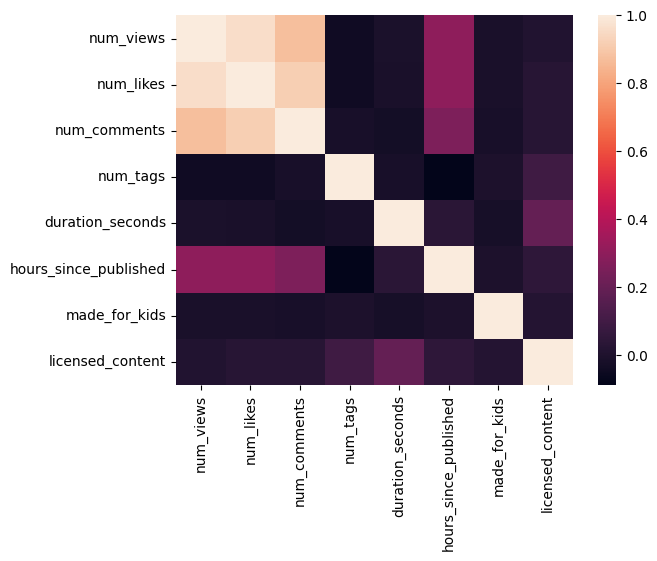

In [182]:
sns.heatmap(all_1week[corr_cols].corr())

In [207]:
best_categories = all_1week.groupby("category_name")["num_views"].median().sort_values(ascending=False)
best_categories = best_categories.reset_index()
best_categories.columns = ["category_name", "median_views"]
best_categories

,category_name,median_views
0,Music,2170852.0
1,Science & Technology,2073504.0
2,Pets & Animals,1864318.0
3,Film & Animation,1658921.0
4,Education,1425313.0
5,Comedy,1346431.0
6,News & Politics,1272377.5
7,Entertainment,1190414.5
8,Travel & Events,1106033.0
9,Howto & Style,961024.0


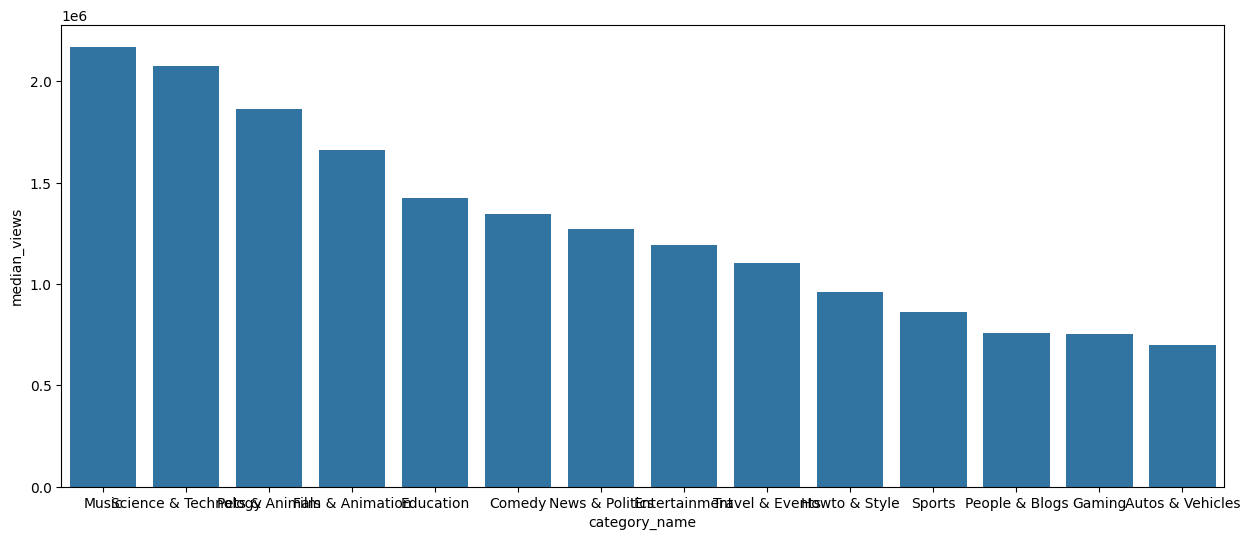

In [208]:
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.barplot(data=best_categories, x="category_name", y="median_views", ax=ax)

Music, Science & Technology, and Pets & Animals perform the best when removing outliers.

In [209]:
mean_best_cat = all_1week.groupby("category_name")["num_views"].agg(np.mean).sort_values(ascending=False)
mean_best_cat

category_name
Entertainment           5.094704e+06
Music                   4.885317e+06
Film & Animation        4.502026e+06
Science & Technology    3.001543e+06
News & Politics         2.278340e+06
Pets & Animals          1.864318e+06
Comedy                  1.845710e+06
Education               1.813490e+06
Sports                  1.787225e+06
Howto & Style           1.561875e+06
People & Blogs          1.343539e+06
Gaming                  1.164431e+06
Travel & Events         1.012866e+06
Autos & Vehicles        9.480203e+05
Name: num_views, dtype: float64

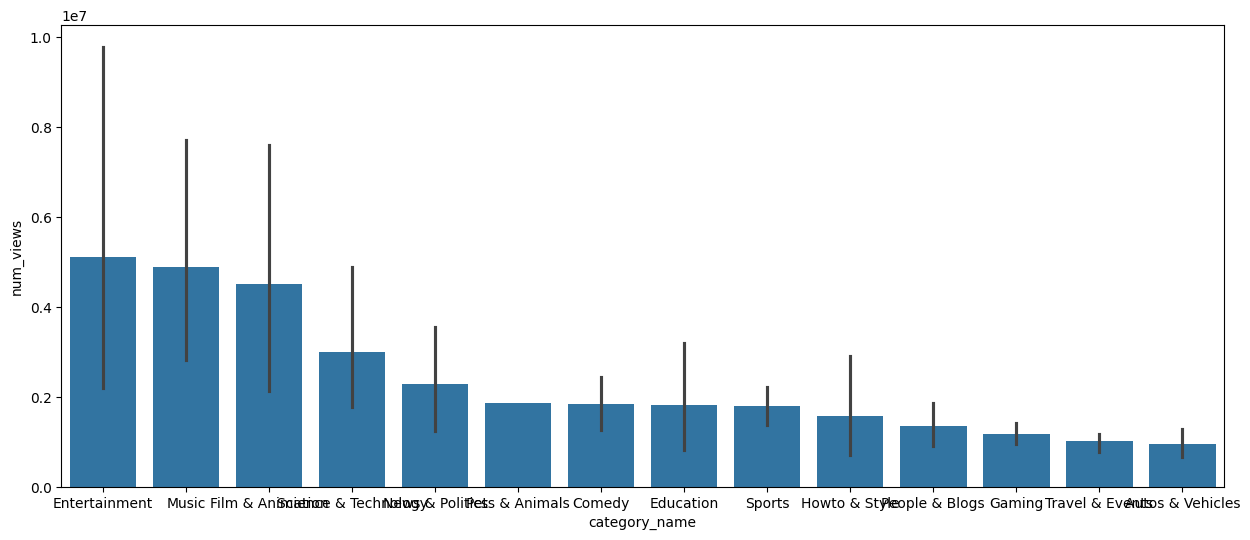

In [210]:
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.barplot(data=all_1week, x="category_name", y="num_views", order=mean_best_cat.index,
                 ax=ax)

Entertainment, Music, and Film & Animation dominate when looking at average views. They also have the largest variances.

## What types of channels perform the best?
Judging based off one week performance

In [185]:
corr_cols

['num_views',
 'num_likes',
 'num_comments',
 'num_tags',
 'duration_seconds',
 'hours_since_published',
 'made_for_kids',
 'licensed_content']

In [186]:
all_1week.columns

Index(['video_collected_at', 'video_id', 'num_views', 'num_likes',
       'num_comments', 'channel_id', 'video_title', 'video_description',
       'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
       'video_published_at', 'category_id', 'category_name',
       'hours_since_published', 'channel_collected_at', 'channel_total_views',
       'num_subscribers', 'channel_num_videos', 'channel_name',
       'channel_created_at', 'channel_days_since_created'],
      dtype='object')

In [187]:
ch_corr_cols = ["num_views", "channel_total_views", "num_subscribers", "channel_num_videos", "channel_days_since_created"]

<Axes: >

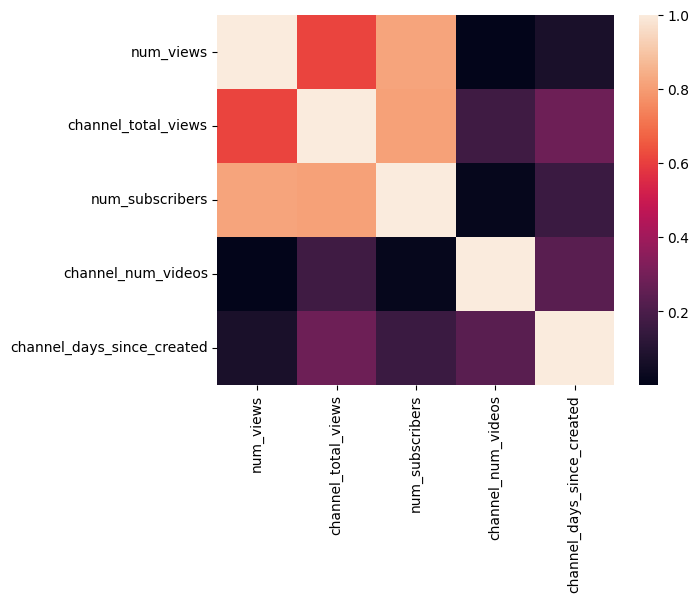

In [188]:
sns.heatmap(all_1week[ch_corr_cols].corr())

Age of the channel and number of uploaded videos do not correlate with views. Number of subscribers strongly correlates with views and total channel views correlated well with the number of views a video has 1 week after showing up on most popular.

## Is there a best day of week or time of day to upload?
Judging based off one week performance.

In [192]:
best_upload = pd.concat([all_1week["num_views"], all_1week["video_published_at"].dt.dayofweek, all_1week["video_published_at"].dt.hour], axis=1)
best_upload.columns = ["num_views", "published_dayofweek", "published_hourofday"]
best_upload

,num_views,published_dayofweek,published_hourofday
0,10178441,4,13
1,2019230,4,22
2,16876175,4,5
3,904825,4,15
4,3473190,3,15
...,...,...,...
583,1030087,2,18
584,1106033,5,15
585,1164978,5,15
586,767587,2,12


In [194]:
day_dict = {0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}
best_upload["published_dayofweek"] = best_upload["published_dayofweek"].map(lambda x: day_dict[x])
best_upload

,num_views,published_dayofweek,published_hourofday
0,10178441,Friday,13
1,2019230,Friday,22
2,16876175,Friday,5
3,904825,Friday,15
4,3473190,Thursday,15
...,...,...,...
583,1030087,Wednesday,18
584,1106033,Saturday,15
585,1164978,Saturday,15
586,767587,Wednesday,12


### Best day of week to upload

In [218]:
best_dayofweek = best_upload.groupby("published_dayofweek")["num_views"].median().sort_values(ascending=False)
best_dayofweek = best_dayofweek.reset_index()
best_dayofweek.columns = ["dayofweek", "median_views"]
best_dayofweek

,dayofweek,median_views
0,Friday,1705702.0
1,Saturday,1484062.0
2,Thursday,1080920.0
3,Monday,935844.0
4,Sunday,918442.0
5,Tuesday,791703.0
6,Wednesday,751438.0


<Axes: xlabel='dayofweek', ylabel='median_views'>

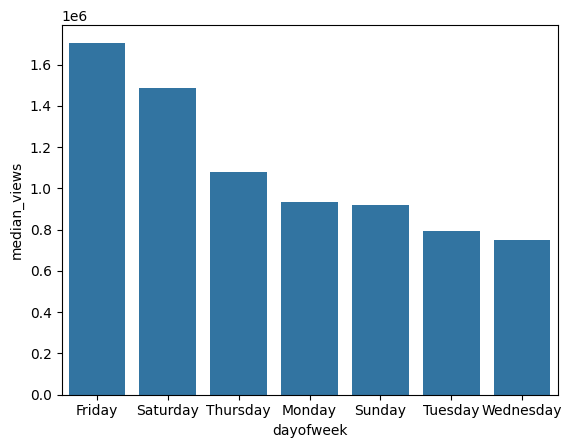

In [223]:
# fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(data=best_dayofweek, x="dayofweek", y="median_views")

Friday and Saturday uploads get the most views. Tuesday and Wednesday uploads get the least.

### Best hour of day to upload

In [225]:
best_hourofday = best_upload.groupby("published_hourofday")["num_views"].median().sort_values(ascending=False)
best_hourofday = best_hourofday.reset_index()
best_hourofday.columns = ["hourofday", "median_views"]
best_hourofday

,hourofday,median_views
0,9,2089177.0
1,1,1544372.0
2,7,1384634.0
3,16,1347753.0
4,13,1316687.0
5,15,1308399.0
6,4,1278841.0
7,6,1269808.0
8,19,1238108.0
9,8,1191883.0


9am, 1am, and 7am have the best performance.

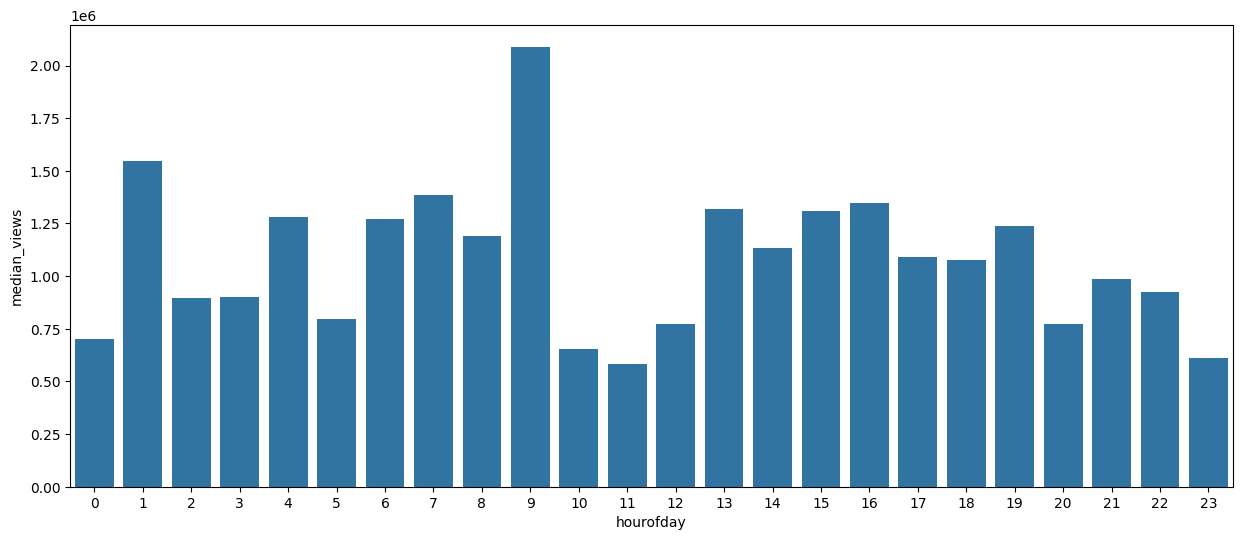

In [228]:
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.barplot(data=best_hourofday, x="hourofday", y="median_views", ax=ax)